In [1]:
from keras import models, layers
from keras.preprocessing import image
import numpy as np

C:\Users\bin b zhu\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
model = models.load_model('cats_and_dogs_small_2.h5')

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)       147584    
__________

In [3]:
img = image.load_img('PetImages/1.jpg', target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

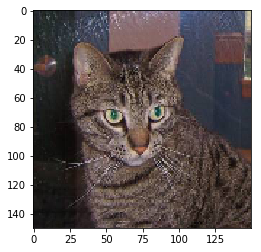

In [5]:
plt.imshow(img_tensor[0])

In [6]:
layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [7]:
activations = activation_model.predict(img_tensor)

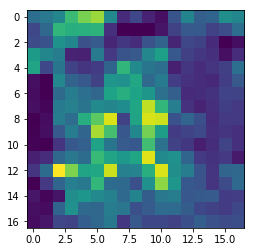

In [17]:
plt.imshow(activations[5][0, :, :, 0], cmap='viridis')

In [18]:
from keras.applications import VGG16
import keras.backend as K

In [6]:
model_vgg = VGG16(weights='imagenet', include_top=False)

In [47]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    
    return x

In [49]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model_vgg.get_layer(layer_name).output
    
    loss = K.mean(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, model_vgg.input)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    iterate = K.function([model_vgg.input], [loss, grads])
    
    input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    return deprocess_image(input_img_data[0])

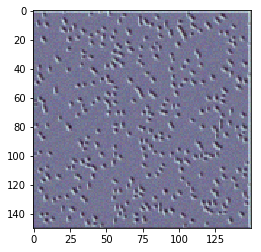

In [53]:
pattern = generate_pattern('block1_conv1', 4)
plt.imshow(pattern)

In [19]:
from keras.applications.vgg16 import preprocess_input, decode_predictions

In [20]:
model_vgg_full = VGG16(weights='imagenet')

In [21]:
img = image.load_img('PetImages/1.jpg', target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

In [22]:
preds = model_vgg_full.predict(x)

In [23]:
decode_predictions(preds)[0]

[('n02123045', 'tabby', 0.4315324),
 ('n02124075', 'Egyptian_cat', 0.3835838),
 ('n02123159', 'tiger_cat', 0.17147405),
 ('n04589890', 'window_screen', 0.005489268),
 ('n02127052', 'lynx', 0.0026715843)]

In [24]:
np.argmax(preds[0])

281

In [27]:
model_vgg_full.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [28]:
tabby_output = model_vgg_full.output[:, 281]
last_conv_layer = model_vgg_full.get_layer('block5_conv3')

In [30]:
grads = K.gradients(tabby_output, last_conv_layer.output)[0]
pooled_grads = K.mean(grads, axis=(0, 1, 2))

In [31]:
iterate = K.function([model_vgg_full.input], [pooled_grads, last_conv_layer.output[0]])

In [35]:
pooled_grads_value, conv_layer_output = iterate([x])
for i in range(512):
    conv_layer_output[:, :, i] *= pooled_grads_value[i]

In [73]:
heatmap = np.mean(conv_layer_output, axis=-1)

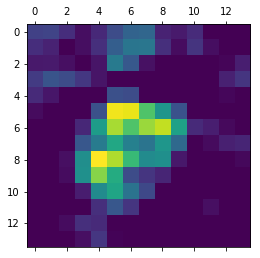

In [75]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

In [48]:
import cv2

In [69]:
img_cv = cv2.imread('PetImages/1.jpg')

In [77]:
heatmap = cv2.resize(heatmap, (img_cv.shape[1], img_cv.shape[0]))
heatmap = np.uint8(255 * heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

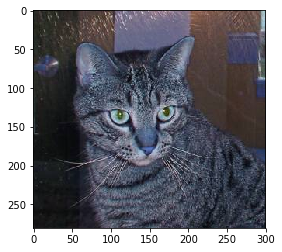

In [76]:
plt.imshow(img_cv)

In [84]:
superimposed_img = heatmap * 0.4 + img_cv

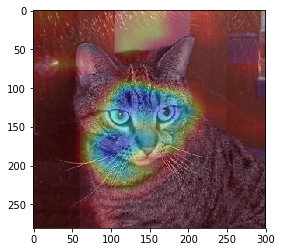

In [83]:
plt.imshow(superimposed_img / np.max(superimposed_img))

In [81]:
cv2.imwrite('PetImages/1_.jpg', superimposed_img)

True